# Adsorption models

At the core of chromatographic processes are interactions between the atoms, ions or molecules of a gas, liquid or dissolved solid with a stationary phase.
These interactions can often be described in terms of an isotherm which relates the amount of adsorbate on the adsorbent as a function of its pressure (in gas phase) or concentration (in solution) at constant temperature.

In CADET, many different models for adsorption are implemented.
All of the models can be modelled kinetically or in rapid equilibrium. 
Moreover, many of them include features such as competitive effects, multi state binding, or a mobile phase modifier.

![Picture1.png](resources/Picture1.png)
 
**In this lesson,** we will:
- Learn about different adsorption models.
- Associate adsorption models with different unit operations.

## Example 1: Linear model

The simplest model for adsorption is the [linear model](https://cadet.github.io/master/modelling/binding/linear.html).
Analogously to Henry's law, it describes a linear correlation of the amount of the surface adsorbate to the partial pressure of the adsorptive gas or the concentration of the solute.


Let us consider a shaking flask experiment a `CSTR` (without ingoing or outgoing streams).
In it, we add some porous material s.t.
- the overal porosity is $0.5$.
- the volume is $1~L$

Then, we add a solution of a component with $1~mol \cdot L^{-1}$. 

In [1]:
from CADETProcess.processModel import ComponentSystem

component_system = ComponentSystem(1)

In [2]:
from CADETProcess.processModel import Linear

binding_model = Linear(component_system, name='linear')
binding_model.is_kinetic = True
binding_model.adsorption_rate = [2]
binding_model.desorption_rate = [1]

In [3]:
from CADETProcess.processModel import Cstr

reactor = Cstr(component_system, name='reactor')
reactor.porosity = 0.5
reactor.binding_model = binding_model
reactor.c = [1]
reactor.V = 1e-3
reactor.solution_recorder.write_solution_bulk = True
reactor.solution_recorder.write_solution_solid = True

In [4]:
from CADETProcess.processModel import FlowSheet

flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(reactor)

In [5]:
from CADETProcess.processModel import Process

process = Process(flow_sheet, 'process')
process.cycle_time = 10

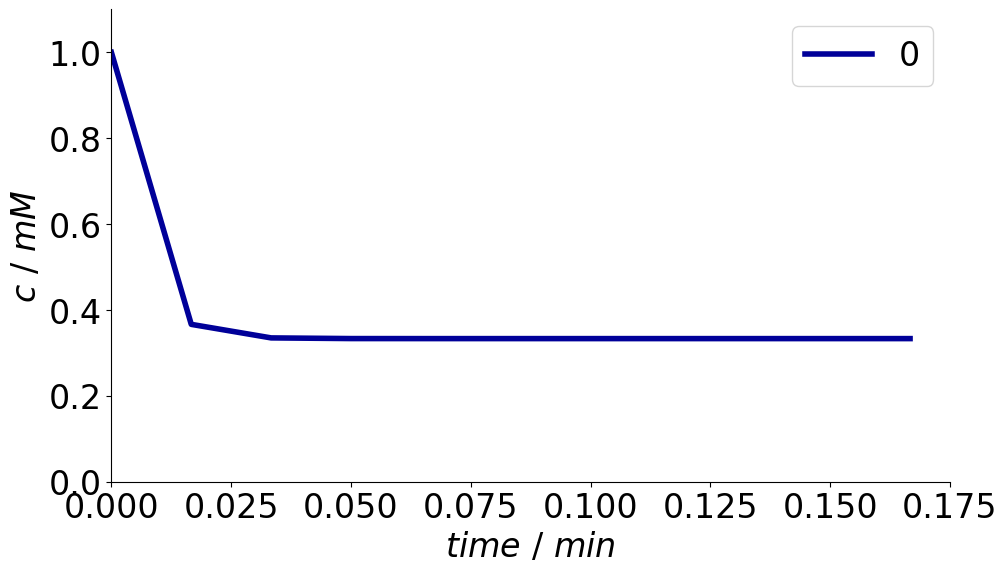

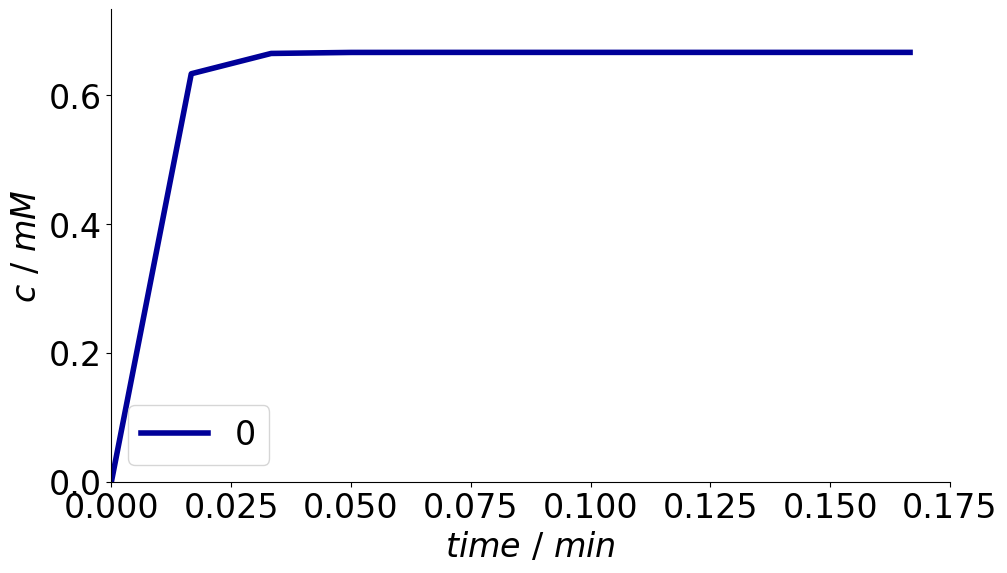

In [6]:
from CADETProcess.simulator import Cadet
simulator = Cadet()
sim_results = simulator.run(process)

_ = sim_results.solution.reactor.bulk.plot()
_ = sim_results.solution.reactor.solid.plot()

### A note on resolution
As can be seen in the figure abore, the time resolution is not sufficiently high.
By default, CADET-Process stores 1 sample per second.
To increase the resolution, set the `time_resolution` parameter of the `Simulator`.

In [7]:
simulator.time_resolution = 0.1

Now, the solution looks much smoother.

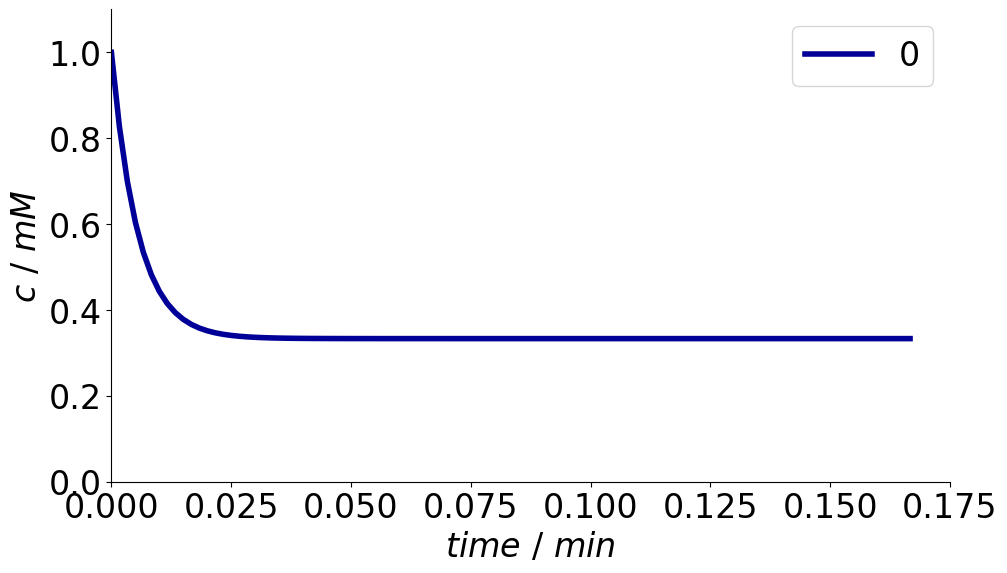

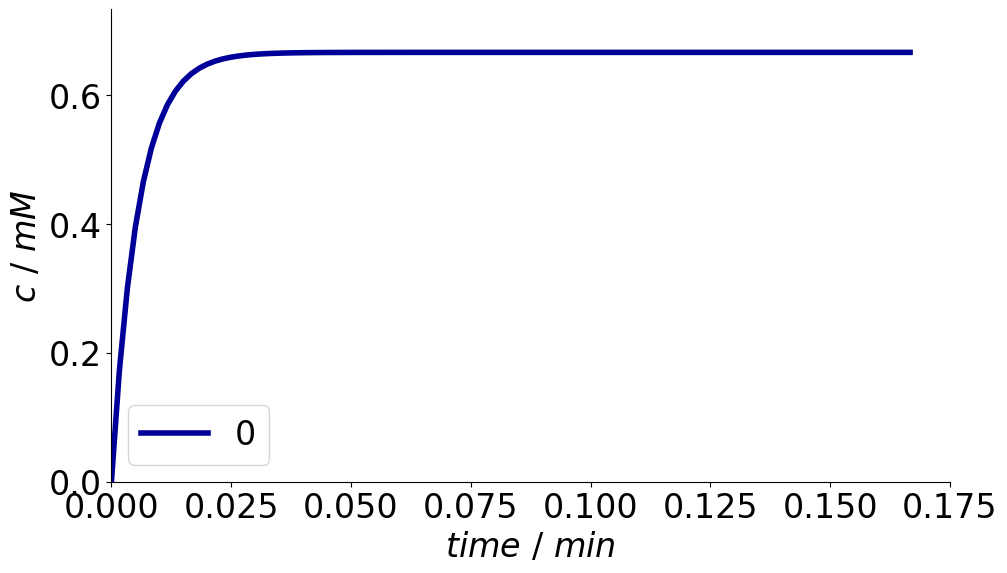

In [8]:
sim_results = simulator.run(process)

_ = sim_results.solution.reactor.bulk.plot()
_ = sim_results.solution.reactor.solid.plot()

## Example 2: Linear adsorption model with linear concentration gradient

To plot the solid phase concentration as a function of the bulk concentration, we can introduce a linear concentration gradient to the `CSTR` that has an initial concentration of $0~mM$.
For this purpose, we will make use of the `flowrate_filter` function of the `CSTR` (see [here](https://cadet.github.io/master/interface/unit_operations/cstr.html)).
This way, we can add mass (or particles) to the tank without increasing it's volume.

In [9]:
from CADETProcess.processModel import ComponentSystem

component_system = ComponentSystem(2)

In [10]:
from CADETProcess.processModel import Linear

binding_model = Linear(component_system, name='linear')
binding_model.is_kinetic = False
binding_model.adsorption_rate = [3,2]
binding_model.desorption_rate = [1,1]

In [11]:
from CADETProcess.processModel import Source, Sink, Cstr

reactor = Cstr(component_system, name='reactor')
reactor.porosity = 0.5
reactor.binding_model = binding_model
reactor.V = 1e-3
reactor.flow_rate_filter = 1e-3
reactor.solution_recorder.write_solution_bulk = True
reactor.solution_recorder.write_solution_solid = True

inlet = Source(component_system, name='inlet')
inlet.c = [[0,1,0,0],[0,1,0,0]]
inlet.flow_rate = 1e-3

outlet = Sink(component_system, name= 'outlet')

In [12]:
from CADETProcess.processModel import FlowSheet

flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(reactor)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(outlet)

flow_sheet.add_connection(inlet,reactor)
flow_sheet.add_connection(reactor,outlet)

In [13]:
from CADETProcess.processModel import Process

process = Process(flow_sheet, 'process')
process.cycle_time = 10

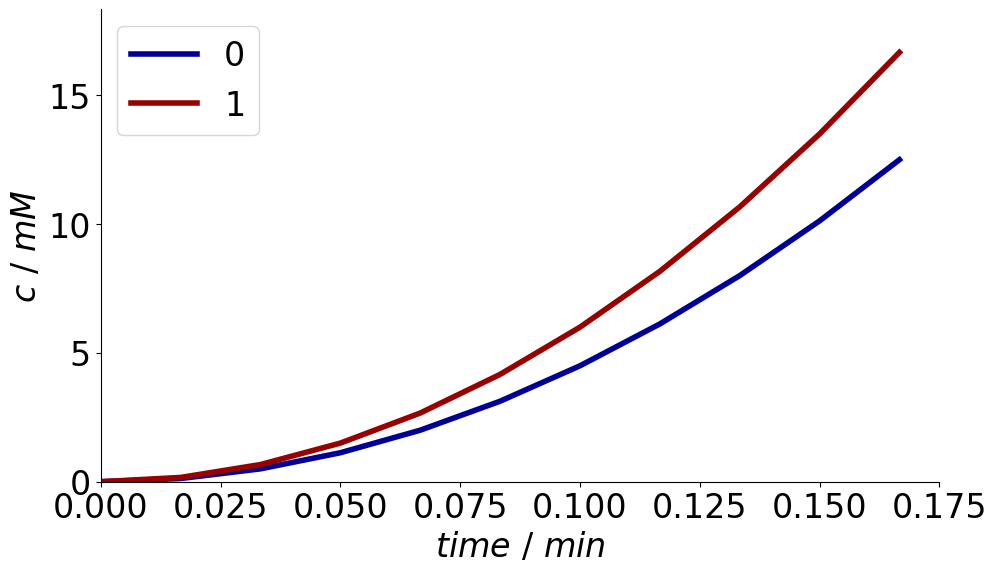

In [14]:
from CADETProcess.simulator import Cadet
simulator = Cadet()
sim_results = simulator.run(process)
_ = sim_results.solution.reactor.outlet.plot()

Text(0, 0.5, '$c_{solid}$')

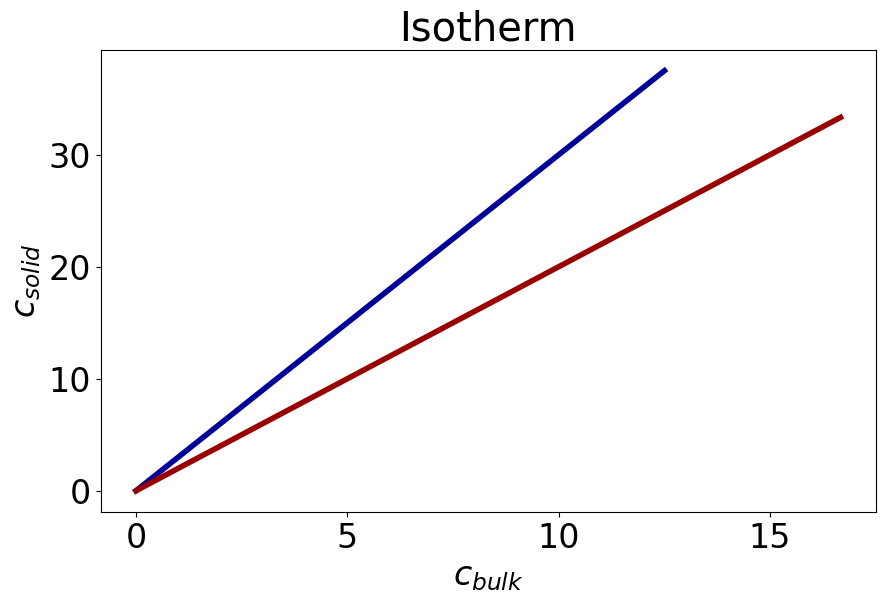

In [15]:
solution_bulk = sim_results.solution.reactor.bulk.solution
solution_solid = sim_results.solution.reactor.solid.solution
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(solution_bulk, solution_solid)
ax.set_title('Isotherm')
ax.set_xlabel('$c_{bulk}$')
ax.set_ylabel('$c_{solid}$')

## Example 3: Multi component Langmuir model

Usually, the linear isotherm can only be assumed for very low solute concentrations.
At higher, higher concentrations the limited number of available binding sites on the surface of the adsorbent also needs to be considered which the [Langmuir equation](https://cadet.github.io/master/modelling/binding/multi_component_langmuir.html) takes into account.

$$q = q_{sat} \cdot \frac{b \cdot c}{1 + b \cdot c} = \frac{a \cdot c}{1 + b \cdot c}$$

***with:*** 
> $q_{Sat}$: saturation loading  
> $b$ = equilibrium factor

***Assumptions:***
- All of the adsorption sites are equivalent, and each site can only accommodate one molecule
- The surface is energetically homogeneous
- Adsorbed molecules do not interact
- There are no phase transitions
- At the maximum adsorption, only a monolayer is formed

For this example, we will introduce a concentration step to the `CSTR`. 
We consider two components, both with an inital concentration of $0~mM$, but with different binding strengths.

In [16]:
from CADETProcess.processModel import ComponentSystem

component_system = ComponentSystem(2)

In [17]:
from CADETProcess.processModel import Langmuir

binding_model = Langmuir(component_system, name='langmuir')
binding_model.is_kinetic = False
binding_model.adsorption_rate = [3,1]
binding_model.desorption_rate = [1,1]
binding_model.capacity = [1,1]

In [18]:
from CADETProcess.processModel import Source, Sink, Cstr

reactor = Cstr(component_system, name='reactor')
reactor.porosity = 0.5
reactor.binding_model = binding_model
reactor.V = 1e-3
reactor.flow_rate = 1e-3
reactor.solution_recorder.write_solution_bulk = True
reactor.solution_recorder.write_solution_solid = True

inlet = Source(component_system, name='inlet')
inlet.c = [1,1]
inlet.flow_rate = 1e-3

outlet = Sink(component_system, name= 'outlet')

In [19]:
from CADETProcess.processModel import FlowSheet

flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(reactor)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(outlet)

flow_sheet.add_connection(inlet,reactor)
flow_sheet.add_connection(reactor,outlet)

In [20]:
from CADETProcess.processModel import Process

process = Process(flow_sheet, 'process')
process.cycle_time = 10

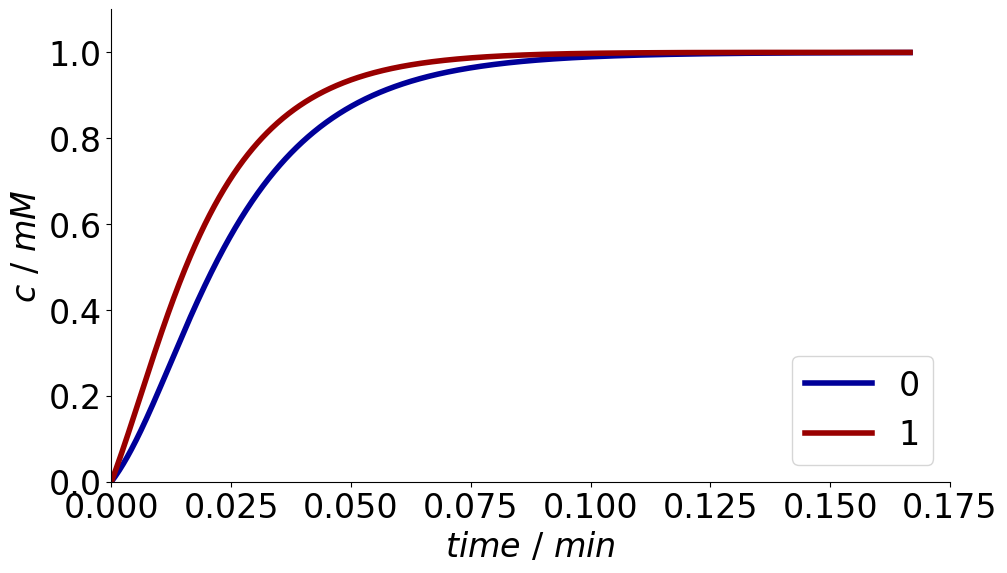

In [21]:
from CADETProcess.simulator import Cadet

simulator = Cadet()
simulator.time_resolution = 0.01

sim_results = simulator.run(process)
_ = sim_results.solution.reactor.outlet.plot()

Text(0, 0.5, '$c_{solid}$')

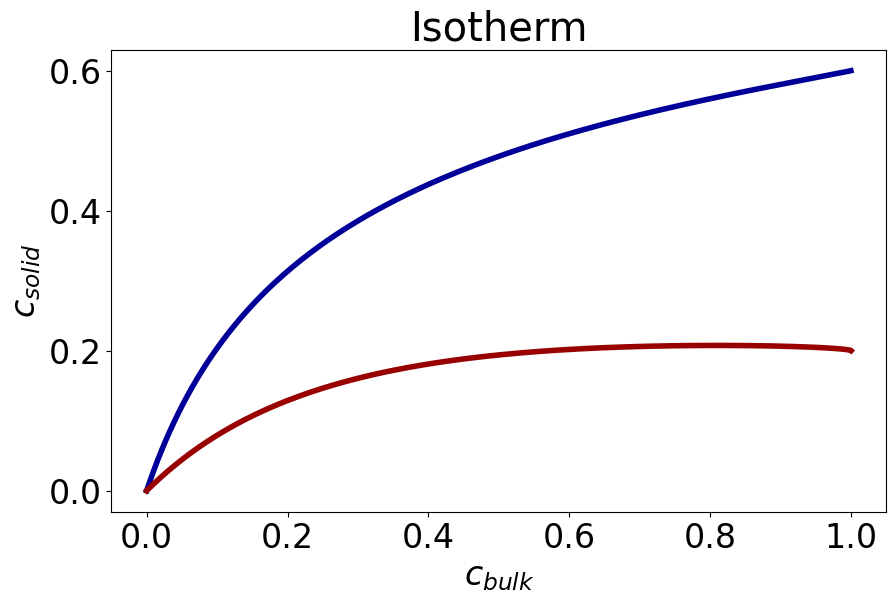

In [22]:
solution_bulk = sim_results.solution.reactor.bulk.solution
solution_solid = sim_results.solution.reactor.solid.solution
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(solution_bulk, solution_solid)
ax.set_title('Isotherm')
ax.set_xlabel('$c_{bulk}$')
ax.set_ylabel('$c_{solid}$')